<a href="https://www.nvidia.com/dli"> <img src="images/combined_logo.png" alt="Header" style="width: 400px;"/> </a>

# Disaster Risk Monitoring Using Satellite Imagery #

## 04 - UNOSAT Flood Impact Analysis Case Study ##
In this notebook, we will learn how UNOSAT, the United Nations Satellite Centre, uses satellite imagery and deep learning-based flood detection models to support emergency response efforts. 

**Table of Contents**
<br>
This notebook covers the below sections: 

1. [Background](#s4-1)
2. [Nepal June 2021 Flood Event Case Study](#s4-2)
    * [Sentinel-1 Data](#s4-2.1)
    * [Load Data](#s4-2.2)
    * [Visualize Data](#s4-2.3)
    * [Segmentation Model Inference](#s4-2.4)
    * [Impact Analysis](#s4-2.5)
3. [Near-Real-Time FloodAI Dashboard](#s4-3)
4. [Summary](#s4-4)

<a name='s4-1'></a>
## Background ##
Nepal is a hazard-prone country. Recurring disasters have been monitored throughout the years, including severe floods in 2008, 2014, and 2017. In 2015, following the 7.8-magnitude earthquake, UNOSAT's Emergency Mapping service was activated to provide satellite-derived damage assessment in support of the humanitarian response efforts on the ground. Acting as coordinator for mapping products, UNOSAT integrated the results from various sources in a publicly available web map. Very innovative at the time, this online viewing tool gathered all the analysis results. It also showed images collected from the ground through the newly developed UN ASIGN app. With the crowdsourcing app, individuals are able to send geotagged content, including photos of damages, to validate the satellite imagery-based assessment. Over the years, UNOSAT has worked with different partners in Nepal, providing technical support and implementing different activities to strengthen capacities in using Geospatial Information Technology (GIT) and data for Disaster Risk Management (DRM).  

<p><img src='images/intro-image.png' width=1080></p>

<a name='s4-2'></a>
## Nepal June 2021 Flood Event Case Study ##
In a more recent incident that occurred during June 2021, Nepal was hit by heavy rainfall. Flooding and landslides were reported in many parts of the country and affected thousands of families<sup>[1]</sup>. Later in August of the same year, rainfall intensified again for several consecutive days, resulting in rivers overflowing, landslides triggered across the hills, and widespread inundation in the southern plains. In the affected areas, many houses, informal settlements, and other buildings were destroyed, forcing people to seek refuge with relatives or in temporary shelters. Health and sanitation concerns arose as access to running water became limited, increasing the risk of water-borne disease transmission, and limiting the ability to adhere to preventive measures against COVID-19.

[1] https://reliefweb.int/disaster/fl-2021-000134-npl

To rapidly respond, UNOSAT Rapid Mapping Service deployed the AI flood detection dashboard (shown below). Flood impact statistics such as sqkm of flood and flood affected population by admin units were automatically generated and displayed on the dashboard. UNOSAT FloodAI was able to process all the available Sentinel-1 overlapping with the area of interested shared by the Information Management Unit of the United Nation Resident Coordination Office in Nepal during the 29 days of activation. We will demonstrate the use of the flood segmentation model on Sentinel-1 images captured around July 2nd, 2021, to analyze the impact of the flood. 

<a name='s4-2.1'></a>
### Sentinel-1 Data ###
Sentinel-1 images can be viewed freely from the Alaska Satellite Facility (ASF) Data Search Vertex. Below are the instructions: 

1. Open the [ASF Data Search Vertex](https://search.asf.alaska.edu/#/?searchType=List%20Search)
2. Input the image name: `S1A_IW_GRDH_1SDV_20210702T001952_20210702T002017_038591_048DBF_C0E0` under **"List of Scene Name"**. You can also use [this link](https://search.asf.alaska.edu/#/?searchType=List%20Search&searchList=S1A_IW_GRDH_1SDV_20210702T001952_20210702T002017_038591_048DBF_C0E0&resultsLoaded=true&granule=S1A_IW_GRDH_1SDV_20210702T001952_20210702T002017_038591_048DBF_C0E0-GRD_HD&zoom=7.200&center=84.451,25.003). 
<p><img src='images/ASF_screen.png' width=720></p>
3. Find the image name in the bottom left corner
4. Click **"Zoom to scene"**
<p><img src='images/ASF_click.png' width=720></p>

**Note**: no ASF login required. 

<a name='s4-2.2'></a>
### Load Data ###
The Sentinel-1 images have been downloaded and pre-processed using the [ESA SNAP toolbox](https://step.esa.int/main/toolboxes/snap/). Below, we will load the two polarizations of Sentinel-1, namely VV and VH, and combine them into an RGB image. 

In [1]:
# DO NOT CHANGE THIS CELL
# import dependencies
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.image as mpimg
import warnings 
import gc
import random

warnings.filterwarnings('ignore')

First, we need to unzip the `UNOSAT_case_study.zip` file, which includes all of the data.

In [2]:
# DO NOT CHANGE THIS CELL
# unzip data file
!unzip data/UNOSAT_case_study.zip -d UNOSAT_case_study

Archive:  data/UNOSAT_case_study.zip
   creating: UNOSAT_case_study/baseline_maps/
  inflating: UNOSAT_case_study/baseline_maps/permanent_water_sample.PNG  
  inflating: UNOSAT_case_study/baseline_maps/world_pop_sample.PNG  
  inflating: UNOSAT_case_study/baseline_maps/analysis_extent.png  
  inflating: UNOSAT_case_study/baseline_maps/world_pop.png  
  inflating: UNOSAT_case_study/baseline_maps/permanent_water.png  
  inflating: UNOSAT_case_study/baseline_maps/analysis_extent_sample.PNG  
   creating: UNOSAT_case_study/tiles_VH/
  inflating: UNOSAT_case_study/tiles_VH/tile_36_44.png  
  inflating: UNOSAT_case_study/tiles_VH/tile_28_25.png  
  inflating: UNOSAT_case_study/tiles_VH/tile_17_9.png  
  inflating: UNOSAT_case_study/tiles_VH/tile_27_53.png  
  inflating: UNOSAT_case_study/tiles_VH/tile_22_49.png  
  inflating: UNOSAT_case_study/tiles_VH/tile_19_34.png  
  inflating: UNOSAT_case_study/tiles_VH/tile_37_16.png  
  inflating: UNOSAT_case_study/tiles_VH/tile_8_27.png  
  inflating

In [3]:
# DO NOT CHANGE THIS CELL
# set environment variables
os.environ['NEPAL_VV_PATH']='/dli/task/UNOSAT_case_study/tiles_VV'
os.environ['NEPAL_VH_PATH']='/dli/task/UNOSAT_case_study/tiles_VH'

# list all VV tiles
!ls $NEPAL_VV_PATH

tile_10_0.png	tile_18_18.png	tile_24_8.png	tile_31_51.png	tile_38_40.png
tile_10_1.png	tile_18_19.png	tile_24_9.png	tile_31_52.png	tile_38_41.png
tile_10_10.png	tile_18_2.png	tile_25_0.png	tile_31_53.png	tile_38_42.png
tile_10_11.png	tile_18_20.png	tile_25_1.png	tile_31_54.png	tile_38_43.png
tile_10_12.png	tile_18_21.png	tile_25_10.png	tile_31_55.png	tile_38_44.png
tile_10_13.png	tile_18_22.png	tile_25_11.png	tile_31_56.png	tile_38_45.png
tile_10_14.png	tile_18_23.png	tile_25_12.png	tile_31_57.png	tile_38_46.png
tile_10_15.png	tile_18_24.png	tile_25_13.png	tile_31_58.png	tile_38_47.png
tile_10_16.png	tile_18_25.png	tile_25_14.png	tile_31_59.png	tile_38_48.png
tile_10_17.png	tile_18_26.png	tile_25_15.png	tile_31_6.png	tile_38_49.png
tile_10_18.png	tile_18_27.png	tile_25_16.png	tile_31_60.png	tile_38_5.png
tile_10_19.png	tile_18_28.png	tile_25_17.png	tile_31_7.png	tile_38_50.png
tile_10_2.png	tile_18_29.png	tile_25_18.png	tile_31_8.png	tile_38_51.png
tile_10_20.png	tile_18_3.png	tile_25_

<a name='s4-2.3'></a>
### Visualize Data ###
The Sentinel-1 images are divided into tiles of size 512 x 512 so that they are easier to manipulate (as opposed to one large file). 

In [5]:
# DO NOT CHANGE THIS CELL
# define function to create RGB composite from VV and VH bands
def RGB_composite(tile_name): 
    vv=mpimg.imread(os.path.join(os.getenv('NEPAL_VV_PATH'), tile_name))
    red=np.clip(vv, 0, 1)
    
    vh=mpimg.imread(os.path.join(os.getenv('NEPAL_VH_PATH'), tile_name))
    green=np.clip(vh, 0, 1)

    blue=np.clip((vv-vh), 0, 1)
    stacked=np.dstack((red, green, blue))
    return stacked

Displaying tile_38_40.png.
The shape is (512, 512, 3).


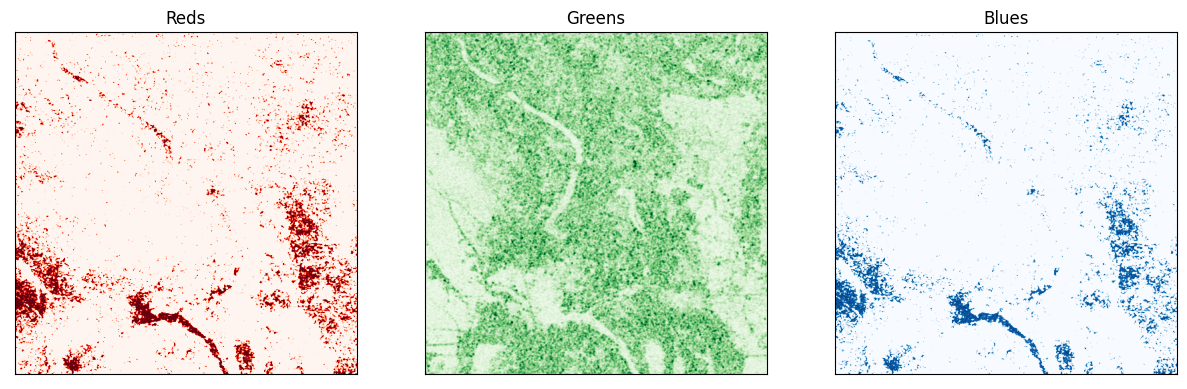

In [6]:
# DO NOT CHANGE THIS CELL
# display the RGB composite of one tile
tile_name=random.choice(os.listdir(os.getenv('NEPAL_VV_PATH')))
print(f'Displaying {tile_name}.')

# create RGB composite
RGB_tile=RGB_composite(tile_name)
cmaps=['Reds', 'Greens', 'Blues']

# plot RGB bands
fig, ax=plt.subplots(1, 3, figsize=(15, 5))

for idx in range(3): 
    ax[idx].imshow(RGB_tile[:, :, idx], cmap=cmaps[idx])
    ax[idx].get_yaxis().set_visible(False)
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].set_title(cmaps[idx])

print(f'The shape is {RGB_tile.shape}.')
plt.show()

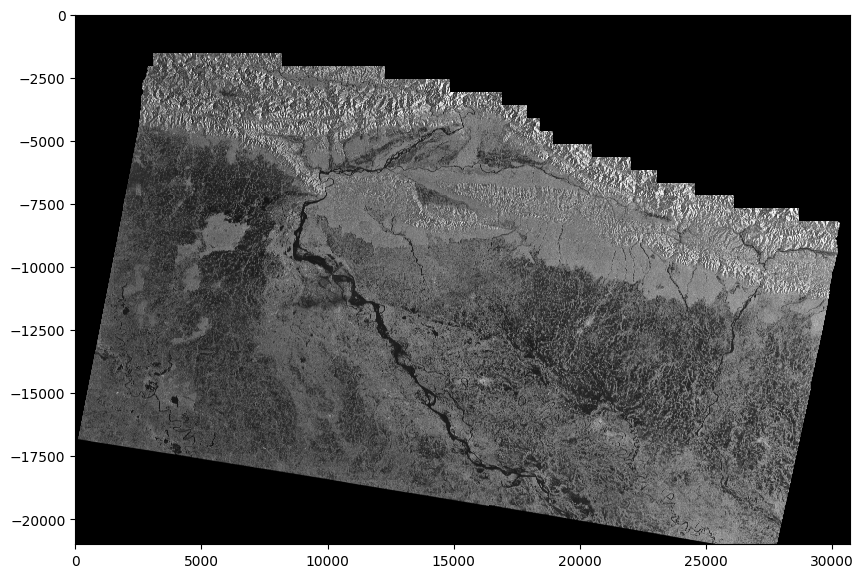

In [7]:
# DO NOT CHANGE THIS CELL
# plot composite for all tiles
fig=plt.figure(figsize=(10, 10))
ax=plt.subplot(111)
max_x, max_y=0, 0

for each_tile in os.listdir(os.environ['NEPAL_VH_PATH']): 
    if (each_tile.split('.')[-1]=='png'): 
        tile_name=each_tile.replace('.png', '')
        _, y, x=tile_name.split('_')
        y=int(y)
        x=int(x)
        if y>max_y: 
            max_y=y
        if x>max_x: 
            max_x=x
        image=mpimg.imread(os.path.join(os.environ['NEPAL_VH_PATH'], each_tile))
        plt.imshow(image, extent=(512*x, 512*(x+1), -512*(y+1), -512*y), cmap='gray')

ax.set_xlim([0, max_x*512])
ax.set_ylim([-max_y*512, 0])
ax.set_facecolor("black")
plt.show()

Processing large image files is memory intensive. To ensure we have sufficient memory for the rest of the notebook, we free up some memory with `del()` and `gc.collect()`. 

In [8]:
# DO NOT CHANGE THIS CELL
del(fig)
del(ax)

gc.collect()
!free

              total        used        free      shared  buff/cache   available
Mem:       28752064     6403328      276700      342112    22072036    21582248
Swap:             0           0           0


You can compare the composite with one that is generated on ASF. 
<p><img src='images/ASF_adjust.png' width=720></p>

<a name='s4-2.4'></a>
### Segmentation Model Inference ###
For inference, we will send requests to the Triton Inference Server to ensure the best performance. We will use the previously trained `sample_resnet18.engine` TensorRT engine, which has been optimized for inference performance. 

In [9]:
# DO NOT CHANGE THIS CELL
!curl -v triton:8000/v2/health/ready

*   Trying 172.18.0.4:8000...
* TCP_NODELAY set
* Connected to triton (172.18.0.4) port 8000 (#0)
> GET /v2/health/ready HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.68.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Length: 0
< Content-Type: text/plain
< 
* Connection #0 to host triton left intact


In [11]:
# DO NOT CHANGE THIS CELL
import tritonclient.http as tritonhttpclient

# set parameters
VERBOSE=False
input_name='input_1'
input_shape=(1, 3, 512, 512)
input_dtype='FP32'
output_name='softmax_1'
model_name='flood_segmentation_model'
url='triton:8000'
model_version='1'

In [12]:
# DO NOT CHANGE THIS CELL
# configure Triton client
triton_client=tritonhttpclient.InferenceServerClient(url=url, verbose=VERBOSE)
model_metadata=triton_client.get_model_metadata(model_name=model_name, model_version=model_version)
model_config=triton_client.get_model_config(model_name=model_name, model_version=model_version)

We will performance inference on the image tiles. Since we are only interested in a specific area, we limit this to a subset of the total tiles. 

In [13]:
# DO NOT CHANGE THIS CELL
# define function to pre-process images for Triton consumption
def get_image_ary(tile_name): 
    image=RGB_composite(tile_name)
    image_ary=((image*255)-127.5)*0.00784313725490196 
    image_ary=np.transpose(image_ary, [2, 0, 1])
    image_ary=np.expand_dims(image_ary, axis=0)
    return image_ary

In [14]:
# DO NOT CHANGE THIS CELL
# configure input and output
inference_input=tritonhttpclient.InferInput(input_name, input_shape, input_dtype)
output=tritonhttpclient.InferRequestedOutput(output_name)

# create one large array by concatenating inference results on individual tiles
prediction_y=[]
for each_y in range(0, 20): 
    prediction_x=[]
    for each_x in range(20): 
        each_file=f'tile_{each_y}_{each_x}.png'
        if each_file in os.listdir(os.getenv('NEPAL_VV_PATH')): 
            # preprocess input tiles
            image_ary=get_image_ary(each_file)
            # genreate inference with Triton
            inference_input.set_data_from_numpy(image_ary)
            response=triton_client.infer(model_name, 
                                         model_version=model_version, 
                                         inputs=[inference_input], 
                                         outputs=[output])
            logits=response.as_numpy(output_name)
            logits=np.asarray(logits, dtype=np.float32)
            mask=np.argmax(logits, axis=3)[0]
            prediction_x.append(mask)
        else: 
            prediction_x.append(np.zeros((512, 512)))
    prediction_y.append(np.concatenate(prediction_x, axis=1))
prediction=np.concatenate(prediction_y, axis=0)

print(f'The result predictions has a shape of {prediction.shape}.')

The result predictions has a shape of (10240, 10240).


<a name='s4-2.5'></a>
### Impact Analysis ###
When performing an impact analysis, we are concerned with:   
- What is the extent of the flood?
- How many people are likely affected or located within flood affected areas?
- What is the estimated number of critical facilities located within the flood affected areas? 

We will use baseline data, which refers to information that provides humanitarian actors with a pre-disaster picture of the potentially affected populations, critical infrastructure, basic geography, and other issues that will become crucial when disaster strikes. Baseline data are obtained from several different sources, each responsible for ensuring accuracy and integrity. Some examples of commonly used baseline data are:

- [Humanitarian Data Exchange](https://data.humdata.org/)
- [Common Operational Datasets ](https://cod.unocha.org/)
- [WorldPop](https://www.worldpop.org/)
- [OpenStreetMap](https://www.openstreetmap.org)
- [Esri 2020 Land Cover Map](https://www.arcgis.com/home/item.html?id=d6642f8a4f6d4685a24ae2dc0c73d4ac)

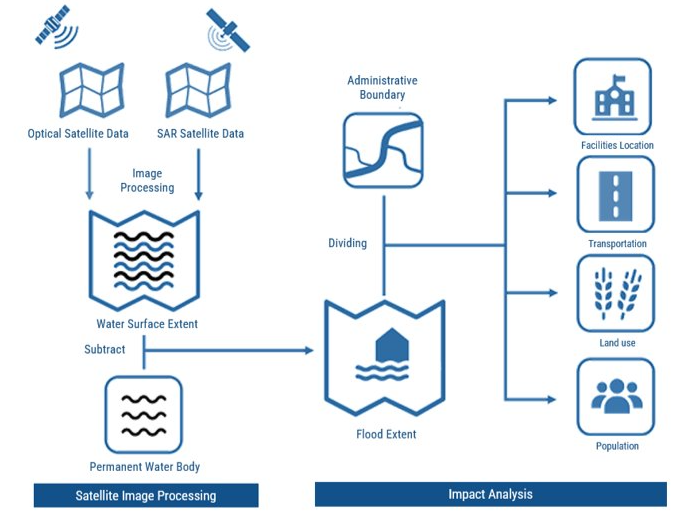

To estimate the population potentially affected by the flood, we will subtract the permanent water from the AI-based water extent. This will be the flood extent that didn't have water pre-disaster. We then intersect the flood extent with the open-source spatial demographic dataset [WorldPop](https://www.worldpop.org/). It is important to notice that there is a discrepancy between Sentinel-1 10-meter resolution and the 100-meter resolution of WorldPop. Resampling the population layer is required to align it with the flood extend before computing any impact analysis. The area of interest for the impact analysis includes the Nawalparasi West, Rupandehi and Kapilbastu districts, and Lumbini province. We curated the permanent water layer and the WorldPop dataset to easily compute the impact analysis. 
<p><img src='images/layers.png' width=480></p>

In [ ]:
# DO NOT CHANGE THIS CELL
# load baseline data
analysis_extent=mpimg.imread('UNOSAT_case_study/baseline_maps/analysis_extent.png')
permanent_water=mpimg.imread('UNOSAT_case_study/baseline_maps/permanent_water.png')
world_pop=mpimg.imread('UNOSAT_case_study/baseline_maps/world_pop.png')

all_maps=[{'name': 'Area of Interest', 'map': mpimg.imread('UNOSAT_case_study/baseline_maps/analysis_extent_sample.PNG')}, 
          {'name': 'Permanent Water Region', 'map': mpimg.imread('UNOSAT_case_study/baseline_maps/permanent_water_sample.PNG')}, 
          {'name': 'Population', 'map': mpimg.imread('UNOSAT_case_study/baseline_maps/world_pop_sample.PNG')}]

# plot baseline data
fig, ax=plt.subplots(1, 3, figsize=(30, 10))

for idx, map in enumerate(all_maps): 
    ax[idx].imshow(map['map'])
    ax[idx].get_yaxis().set_visible(False)
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].set_title(map['name'])

In [ ]:
# DO NOT CHANGE THIS CELL
# make a copy of the water extent
flood_extent=prediction.copy()

# focus on the region inside the analyis extent only
flood_extent[analysis_extent==0]=0 

# subtract permanent water 
flood_extent[permanent_water!=0]=0 

# calculate the potentially affected population resempling the WorldPop resolution to the Sentinel-1 resolution. 
affected_population=np.sum(world_pop*255*np.float32(flood_extent)/98.5066598616484) 

print(f"Population potentially affected: {affected_population}.") 

In [ ]:
# DO NOT CHANGE THIS CELL
# plot layers of the impact analysis
fig=plt.figure(figsize=(10, 10))
ax=plt.subplot(111)

# plot map (by tiles)
for each_y in range(20): 
    for each_x in range(20): 
        each_file=f'tile_{each_y}_{each_x}.png'
        if each_file in os.listdir(os.environ['NEPAL_VV_PATH']): 
            image=RGB_composite(each_file)
            plt.imshow(image[:, :, 1], extent=(512*each_x, 512*(each_x+1), -512*(each_y+1), -512*each_y), cmap='gray')

# plot predicted flood extent            
plt.imshow(flood_extent, extent=(0, 10240, -10240, 0), cmap='Reds', alpha=0.5, vmax=3)

# plot area of interest
plt.imshow(analysis_extent, extent=(0, 10240, -10240, 0), cmap='ocean', alpha=0.2)

ax.set_xlim([0, 10240])
ax.set_ylim([-10240, 0])
ax.set_facecolor("black")
plt.show()

The United Nations Satellite Centre (UNOSAT) map, displayed below, indicated a potential exposed population of 195'000  on June 2nd. Is it in line with the number you just obtained? 
<p><img src='images/UNOSAT_A3_Natural_Landscape_FL20210630NPL_Lumbini_07072021-1.jpg' width=720></p>

<a name='s4-3'></a>
## Near-Real-Time FloodAI Dashboard ##
To run flood detection at scale and respond to a growing need for daily updates, it is crucial to develop end-to-end pipelines where satellite images are automatically downloaded and processed by machine learning algorithms to output flood extent. Tools that provide access and disseminate this information could play a key role, such as the [operational dashboards](https://unosat-geodrr.cern.ch/portal/apps/opsdashboard/index.html#/9ae9eea3c6054d36a5a128602ac6d9ac) that UNOSAT developed for the UN Regional Coordination Office in Nepal.

To ensure timely and accurate updates, the AI-generated flood extents are reviewed and corrected as necessary by the UNOSAT Rapid Mapping team, before feeding the dashboard for end user consumption. Another tailor-made feature was the integration of [UN ASIGN](https://www.unitar.org/sustainable-development-goals/united-nations-satellite-centre-unosat/our-portfolio/un-asign), an application that was shared with field officers across the country to upload geotagged information and photos in real time. The UN ASIGN application provided a way to collect and centralize ground data, which was extremely useful during the national lockdown. The visualization of all the data on the same platform provides a comprehensive overview of the area of interest despite movement restrictions.

<p><img src='images/Nepal_dashboard_2021.png' width=720></p>

<a name='s4-4'></a>
## Summary ##
Thank you for completing the NVIDIA DLI Disaster Risk Monitoring Using Satellite Imagery lab. In this lab, you learned how to build and deploy a flood detection segmentation model using data collected from Sentinel-1 satellites. You also learned how flood detection is used to support disaster response. While this lab focuses primarily on detecting flood events, it should be noted that similar applications can be created for other natural disasters.

_This training material is property of the United Nations Satellite Centre (UNOSAT)- UNITAR and was designed, prepared, and delivered exclusively for this course. Please do not reproduce or distribute it without the expressed written permission of UNITAR-UNOSAT._

<a href="https://www.nvidia.com/dli"> <img src="images/combined_logo.png" alt="Header" style="width: 400px;"/> </a>